In [2]:
import torch
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

## Individual parameters

In [75]:
# generation of the individual parameters

n_patients = 300

# individual_parameters
xi_mean = 0
sigma_xi = 0.5
tau_mean = 70
sigma_tau = 12
sources_std = 10

columns = ['xi', 'tau', 'source']
feature_parameters = pd.DataFrame(columns=columns)

for i in range(n_patients):
    xi = np.random.normal(xi_mean, sigma_xi)
    tau = np.random.normal(tau_mean, sigma_tau)
    source = np.random.normal(0,sources_std)
    feature_parameters.loc[i] = [xi, tau, source]
    
feature_parameters.head()

,xi,tau,source
0,-0.692980,102.873124,-6.612634
1,-0.106132,83.123088,-18.134419
2,0.154129,87.899298,0.005569
3,-0.218066,70.157167,-4.220802
4,-0.402675,69.448463,-5.494417


In [76]:
feature_parameters.describe().drop('count')

,xi,tau,source
mean,-0.031255,70.399823,-0.094449
std,0.495057,12.121842,10.436583
min,-1.776552,36.464122,-26.429986
25%,-0.359276,61.631818,-7.768740
50%,-0.052229,70.553563,0.030651
75%,0.279481,79.266656,6.779289
max,1.290700,102.873124,24.728552


# Simulation with closed form geodesics

In [77]:
# logistic sampler from individidual parameters

def logistic(timepoints, acceleration, timeshift, a=0, b=1, spaceshift=None, noise=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first asymptote and second asymptote. By default features go from 0 to 1
    """
    L = np.exp(acceleration)/14*(timepoints - timeshift)
    if noise is not None:
        L = L+noise
    if spaceshift is not None:
        return a + (b-a)/(1+np.exp(-L + spaceshift/20)) 
    return a + (b-a)/(1+np.exp(-L))

def sum_logistic(timepoints, acceleration, timeshift, a=0, b=1, spaceshift=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first asymptote and second asymptote. By default features go from 0 to 1
    """
    Lp = np.exp(acceleration)/3*(np.array(timepoints) - np.array(timeshift)) + 4
    Lm = np.exp(acceleration)/3*(np.array(timepoints) - np.array(timeshift)) - 4
    if spaceshift is not None:
        return a + (b-a)/(1+np.exp(-Lp + spaceshift/3))/2 + (b-a)/(1+np.exp(-Lm + spaceshift/3))/2
    return  a + (b-a)/(1+np.exp(-Lp))/2 + (b-a)/(1+np.exp(-Lm))/2

def linear(timepoints, acceleration, timeshift, a=0, b=1, spaceshift=None):
    """
    - timepoints : real ages of patients at which we want the visits
    - acceleration : feature wise acceleration factor
    - timeshift : feature wise timeshift (point at which the logistic curves hits a fixed value across features)
    - a,b : first 'asymptote' and second 'asymptote'. By default features go from 0 to 1
    """
    m = (b-a)/80
    if spaceshift is not None:
        return a + (b-a)/2 + m*np.exp(acceleration)*(timepoints-timeshift) + m*spaceshift
    return a + (b-a)/2 + m*np.exp(acceleration)*(timepoints-timeshift)

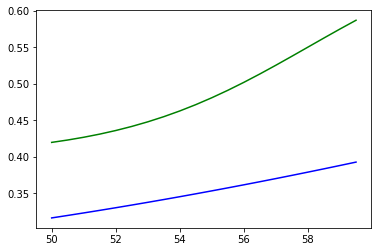

In [54]:
t = np.arange(50,60,0.5)
p1 = logistic(t, 0, 70, 0.2, 0.8, spaceshift=0)
p2 = sum_logistic(t, 0, 70, 0.4, 1, spaceshift=0) 

plt.plot(t,p1,c='b')
plt.plot(t,p2,c='g')

No handles with labels found to put in legend.


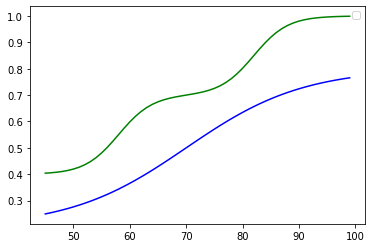

In [55]:
t = np.arange(45,100,1)

#t = np.array([50,50.5,51,52,53])
p1 = logistic(t, 0.3, 70, 0.2, 0.8, spaceshift=0)
p2 = sum_logistic(t, 0, 70, 0.4, 1, spaceshift=0) 
p3 = linear(t, 0, 70, 0.4, 0.9, spaceshift=0)
p1_source_neg = logistic(t, 0, 70, 0.2, 0.8, 8)
p2_source_neg = sum_logistic(t, 0, 70, 0.3, 1, -8) 
p3_source_neg = linear(t, 0, 70, 0.4, 0.9, -8)
p1_source_pos = logistic(t, 0, 70, 0.2, 0.8, -8)
p2_source_pos = sum_logistic(t, 0, 70, 0.3, 1, 8) 
p3_source_pos = linear(t, 0, 70, 0.4, 0.9, 8)

plt.plot(t,p1,c='b')
plt.plot(t,p2,c='g')

"""
plt.plot(t,p3,c='r')
plt.plot(t,p1_source_pos)
plt.plot(t,p1_source_neg)
plt.plot(t,p3_source_pos)
plt.plot(t,p3_source_neg)
"""
plt.legend()
plt.show()


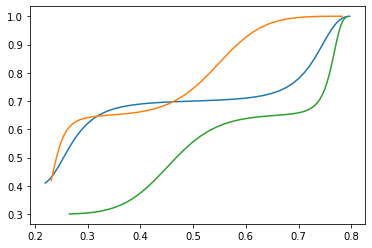

In [15]:
plt.plot(p1,p2)
plt.plot(p1_source_neg,p2_source_neg)
plt.plot(p1_source_pos,p2_source_pos)

In [78]:
# generate the associated trajectories 

visits_per_patients = 8
time_between_visits = 0.5
columns = ['feat1', 'feat2']

noise_std = 0.02

data = []
for sub in feature_parameters.index:
    id_params = feature_parameters.loc[sub]
    time_first_visit = np.random.normal(loc=70, scale=10)
    timepoints = [time_first_visit + i*time_between_visits for i in range(visits_per_patients)]
    feature_1 = logistic(np.array(timepoints), id_params[0], id_params[1], a=0.2, b=0.8, spaceshift=-id_params[2]/2) + np.random.normal(0, noise_std, visits_per_patients)
    feature_2 = sum_logistic(np.array(timepoints), id_params[0], id_params[1], a=0.4, b=1, spaceshift=id_params[2]/2)+ np.random.normal(0, noise_std, visits_per_patients)
    #feature_2 = linear(np.array(timepoints), id_params[0], id_params[1], a=0.4, b=0.9, spaceshift=id_params[2]/2)+ np.random.normal(0, noise_std, visits_per_patients)

    sub_data = pd.DataFrame([timepoints,feature_1, feature_2]).T
    sub_data.columns = ['TIME', 'feat1', 'feat2']
    sub_data['ID'] = sub
    sub_data = sub_data.set_index(['ID'])
    
    data.append(sub_data)
    
data = pd.concat(data)

In [79]:
# Histogram of reparametrized ages

ages = []
for sub in data.index.unique():
    ip = feature_parameters.loc[sub]
    timepoints = data.loc[sub]['TIME']
    ages += list((np.exp(ip['xi'])*(timepoints - ip['tau']) + 70).values)
    

(array([  3.,   2.,   3.,   0.,   1.,   7.,   9.,  13.,   8.,   2.,   5.,
         23.,  45.,  57.,  55.,  81., 111., 125., 185., 195., 220., 161.,
        225., 210., 108., 156.,  84.,  53.,  55.,  50.,  39.,  26.,  20.,
         22.,  11.,   6.,   5.,   6.,   7.,   6.]),
 array([-1.08420983e-01,  3.25127720e+00,  6.61097539e+00,  9.97067358e+00,
         1.33303718e+01,  1.66900700e+01,  2.00497681e+01,  2.34094663e+01,
         2.67691645e+01,  3.01288627e+01,  3.34885609e+01,  3.68482591e+01,
         4.02079573e+01,  4.35676555e+01,  4.69273536e+01,  5.02870518e+01,
         5.36467500e+01,  5.70064482e+01,  6.03661464e+01,  6.37258446e+01,
         6.70855428e+01,  7.04452410e+01,  7.38049391e+01,  7.71646373e+01,
         8.05243355e+01,  8.38840337e+01,  8.72437319e+01,  9.06034301e+01,
         9.39631283e+01,  9.73228265e+01,  1.00682525e+02,  1.04042223e+02,
         1.07401921e+02,  1.10761619e+02,  1.14121317e+02,  1.17481016e+02,
         1.20840714e+02,  1.24200412e+02, 

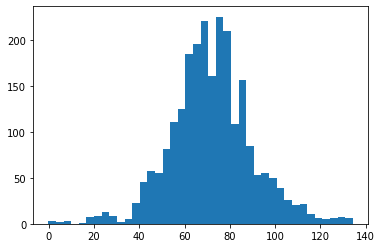

In [80]:
plt.hist(ages, bins=40)

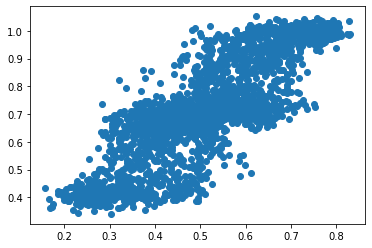

In [81]:
plt.scatter(data['feat1'], data['feat2'])

In [66]:
data.describe(percentiles=[.1,.2,.8,.95])

,TIME,feat1,feat2
count,3200.000000,3200.000000,3200.000000
mean,71.826074,0.514624,0.716598
std,10.878439,0.155165,0.194385
min,33.158610,0.170978,0.343383
10%,57.238331,0.294557,0.412109
20%,62.310205,0.363093,0.529192
50%,72.588681,0.517996,0.709280
80%,80.661584,0.659160,0.953621
95%,89.681767,0.767097,1.009338
max,103.359220,0.844186,1.053083


In [ ]:
data

In [82]:
data_path = 'simulated_study/simulated_data_1/'
data.to_csv(data_path + 'simulated_data_test.csv')
feature_parameters.to_csv(data_path + 'true_individual_parameters.csv')

## Save the data 

In [83]:
X = data['TIME'].values
Y = data[['feat1', 'feat2']].values
group = [int(sub) for sub in data.index.values]

In [84]:
np.savetxt(data_path + 'X.csv', X)
np.savetxt(data_path + 'Y.csv', Y, delimiter=',')
np.savetxt(data_path + 'group.csv', group)

In [25]:
data.describe(percentiles=[.1,.2,.3,.5,.7,.8,.9, .95])

,TIME,feat1,feat2
count,1800.000000,1800.000000,1800.000000
mean,76.303536,0.568025,0.725008
std,15.990967,0.133968,0.167139
min,32.112238,0.176869,0.268439
10%,55.493920,0.376076,0.564416
20%,64.032295,0.462833,0.627668
30%,68.394799,0.510303,0.649337
50%,76.157909,0.579065,0.686779
70%,84.474855,0.653867,0.801910
80%,88.643203,0.690594,0.908268


# Simulating with a metric

In [1]:
import numpy as np
import pandas as pd
import torch
import sys
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('/home/benoit.sautydechalon/deformetrica')

from deformetrica.core.estimator_tools.samplers.srw_mhwg_sampler import SrwMhwgSampler
from deformetrica.core.estimators.gradient_ascent import GradientAscent
from deformetrica.core.estimators.mcmc_saem import McmcSaem
# Estimators
from deformetrica.core.estimators.scipy_optimize import ScipyOptimize
from deformetrica.core.model_tools.manifolds.exponential_factory import ExponentialFactory
from deformetrica.core.model_tools.manifolds.generic_spatiotemporal_reference_frame import GenericSpatiotemporalReferenceFrame
from deformetrica.core.models.longitudinal_metric_learning import LongitudinalMetricLearning
from deformetrica.core.models.model_functions import create_regular_grid_of_points
from deformetrica.in_out.array_readers_and_writers import read_2D_array
from deformetrica.in_out.dataset_functions import read_and_create_scalar_dataset, read_and_create_image_dataset
from deformetrica.support.probability_distributions.multi_scalar_normal_distribution import MultiScalarNormalDistribution
from deformetrica.support.utilities.general_settings import Settings
from deformetrica import estimate_longitudinal_metric_model
from deformetrica.in_out.array_readers_and_writers import *
from deformetrica.launch.estimate_longitudinal_metric_model import instantiate_longitudinal_metric_model
import deformetrica as dfca

[pyKeOps]: Warning, cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [3]:
path = 'simulated_study'
args = {'verbosity':'INFO', 'output':'personalize',onn
        'model':path+'/model_7.xml', 'dataset':path+'/data_set.xml', 'parameters':path+'/optimization_parameters_saem.xml'}


"""
Read xml files, set general settings, and call the adapted function.
"""

xml_parameters = dfca.io.XmlParameters()
xml_parameters.read_all_xmls(args['model'],
                             args['dataset'],
                             args['parameters'])

logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logger.setLevel(logging.INFO)

In [4]:
dataset = read_and_create_scalar_dataset(xml_parameters)
model, individual_RER = instantiate_longitudinal_metric_model(xml_parameters, logger, dataset, observation_type='scalar')

In [8]:
onset_ages = torch.tensor(feature_parameters['tau'])
log_accelerations = torch.tensor(feature_parameters['xi'])
sources = torch.tensor([[float(source)] for source in feature_parameters['source'].values])

In [9]:
# Timepoints of visits

visits_per_patients = 12
time_between_visits = 0.5

noise_std = 0.02

timepoints_lst = []
timepoints = []

for sub in feature_parameters.index:
    time_first_visit = np.random.normal(loc=0, scale=10)
    timepoints_lst = timepoints_lst + [time_first_visit + feature_parameters.loc[sub]['tau'] + i*time_between_visits for i in range(visits_per_patients)]
    timepoints.append([time_first_visit + feature_parameters.loc[sub]['tau'] + i*time_between_visits for i in range(visits_per_patients)])

In [10]:
v0, p0, metric_parameters, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
#onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(np.array(timepoints), log_accelerations, onset_ages)

absolute_times_to_write = []
for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

#np.savetxt(os.path.join(Settings().output_dir, "LongitudinalMetricModel_absolute_times.txt"), np.array(absolute_times_to_write))

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, metric_parameters,
                                            modulation_matrix)

Patient  132  was estimated with an absurd timeshift tensor(158.3860)
150 good iterations out of 151
196 good iterations out of 211


In [11]:
predictions = []
subject_ids = []
times = []

targets = dataset.deformable_objects

number_of_subjects = dataset.number_of_subjects
residuals = []

for i in range(number_of_subjects):
    predictions_i = []
    for j, t in enumerate(absolute_times[i]):
        if sources is not None:
            prediction = model.spatiotemporal_reference_frame.get_position(t, sources=sources[i])
        else:
            prediction = model.spatiotemporal_reference_frame.get_position(t)
        predictions_i.append(prediction.cpu().data.numpy())
        predictions.append(prediction.cpu().data.numpy())
        subject_ids.append(dataset.subject_ids[i])
        times.append(dataset.times[i][j])
    targets_i = targets[i].cpu().data.numpy()


In [12]:
feat_1 = [prediction[0] for prediction in predictions]
feat_2 = [prediction[1] for prediction in predictions]

In [13]:
data_path = 'simulated_study/simulated_data_metric_5/'
feature_parameters.to_csv(data_path + 'true_individual_parameters.csv')

## Save the data 

In [19]:
X = np.array(timepoints_lst)
Y = predictions
group = []
for i in range(len(timepoints)):
    group = group + [i for j in range(12)]

In [20]:
data_path = 'simulated_study/simulated_data_metric_5/'

In [21]:
np.savetxt(data_path + 'X.csv', X)
np.savetxt(data_path + 'Y.csv', Y, delimiter=',')
np.savetxt(data_path + 'group.csv', group)

## Add the noise

In [3]:
data_path = 'simulated_study/simulated_data_test/'

In [4]:
data = pd.read_csv(data_path + 'Y.csv', header=None)

In [32]:
noise_std = 0.025

data_noisy = data + np.random.normal(0, noise_std, data.shape)

In [33]:
data_path = 'simulated_study/simulated_data_1/'
np.savetxt(data_path + 'Y.csv', data_noisy.values, delimiter=',')

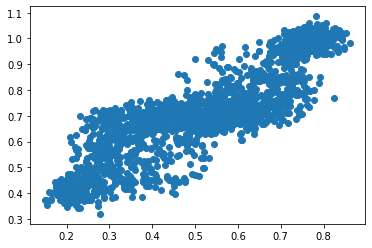

In [35]:
plt.scatter(data_noisy['feat1'], data_noisy['feat2'])